# Capstone project 1: Pet Product Auto-Subcategorization by Review Analysis (modeling)

**Goal: Creating a system that automatically classifies products in Pet Supplies category into subcategories by analyzing the reviews.**  
In this project, the data collected during 2014 - 2015 in the US is used.

This jupyter notebook is about modeling. If you want to see the preprocessing, see the preprocessing jupyter notenbook.

## Recapitulation

The original data was preprocessed and divided into three; cat, dog, and other categories.  
Number of reviews per product, products, reviews, and tokens in each data:
  
| Category | Reviews/product | Total reviews | Total products | Total tokens (unique) |  
|:--------:|:---------------:|:-------------:|:--------------:|:---------------------:|  
|cat|||||
|dog|||||
|other||||||
  
  
Summary statistics of the number of tokens per product:
  
| Category |  Min  |  25%  |  50%  |  75%  |  90%  |  Max|Mean  |  SD  |  
|:--------:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|  
|cat|10|46|60|76|94|235|62.8|24.1|
|dog|||||
|other||||||

## Import packages and define functions

In [234]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import nltk
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from ipywidgets import interact

sns.set(context='notebook', style='ticks', palette='hls')
pd.set_option("display.max_colwidth", 100)

# colors
cmap1 = plt.get_cmap('tab20b') 
cmap2 = plt.get_cmap('tab20c') 
cmap3 = plt.get_cmap('nipy_spectral') 

cmap1_vals = [cmap1(i) for i in range(cmap1.N)]
cmap2_vals = [cmap2(i) for i in range(cmap2.N)]

cmaps = cmap1_vals + cmap2_vals + cmap1_vals + cmap2_vals + cmap1_vals 

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle the code on/off."></form>''')

In [3]:
# Define a function drewing a dendrogram
def plot_dendrogram(model, **kwargs):
    '''
    Create linkage matrix and then plot the dendrogram
    '''

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [4]:
# Define Silhouette analysis
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def silhouette(n_clusters, cluster_labels, features):
    '''
    Draw Shilhouette plot 
    '''

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(7, 7)

    # the silhouette plot
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, features.shape[0] + (n_clusters + 1) * 10])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(features, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                                    facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    # Average silhouette score
    silhouette_avg = np.mean(sample_silhouette_values)
    print("For n_clusters =", n_clusters, ", The average silhouette_score is :", silhouette_avg)
    
    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.show()

In [42]:
# Define Silhouette analysis (only score)
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm

def aggclus_ca_silhouette_score(min_nclus, max_nclus, interval_nclus, features):
    '''
    Do agglomerative clustering and get the Shilhouette score to various number of clusters
    '''
    n_clusters = [i for i in range(min_nclus, max_nclus+1, interval_nclus)]
    scores = []

    for k in n_clusters:
        model = AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='average')
        model = model.fit(features)
        
        score = silhouette_score(features, model.labels_)
        scores.append(round(score, 4))
    
    return n_clusters, scores

In [337]:
def frequent_words(df, label_column, token_list):
    '''
    Find the most frequent 10 words in each cluster
    '''
    n_clusters = df[label_column].nunique()
    df_cluster = pd.DataFrame(columns=['cluster number','frequent words', 'number of products'])
    for i in range(n_clusters):
        words = []
        indexes = df[df[label_column] == i].index
        for index in indexes:
            for word in set(token_list[index]):
                words.append(word)
        c = Counter(words)
        values, _ = zip(*c.most_common(10))

        df_temp = pd.DataFrame([[i, values, len(indexes)]], 
                                columns=['cluster number','frequent words', 'number of products'])
        df_cluster = df_cluster.append(df_temp)

    return df_cluster.set_index('cluster number')

In [235]:
# Scatter plot, coloring by variety_numbers
def cluster_plot(tsne_features, cluster_n, df, cluster_n_column, label_column):
    '''
    Plot the t-SNE image for a big_category cluster with the selected labels
    '''
    plt.figure(figsize=(9,7))

    df_cluster = df[df[cluster_n_column] == cluster_n].sort_index()

    for i in df_cluster[label_column].unique():
        bool_array = (df_cluster[label_column] == i).values
        plt.scatter(tsne_features[cluster_n][bool_array][:,0], 
                    tsne_features[cluster_n][bool_array][:,1], 
                    s=4, alpha=0.8, c=[cmaps[i]], label=i)   
        plt.text(tsne_features[cluster_n][bool_array][:,0][0],
                 tsne_features[cluster_n][bool_array][:,1][0],
                 str(i), color="black", size=16)

## 4. Building the model

#### Approach:

4.1. Cat category  
4.1.1. Loading data  
4.1.2. Vectorization    
4.1.3. Hierarchical clustering  
  
4.2. Dog category  
4.2.1. Loading data  
4.2.2. Vectorization    
4.2.3. Hierarchical clustering 

4.3. Other category  
4.3.1. Loading data  
4.3.2. Vectorization    
4.3.3. Hierarchical clustering 

### 4.1. Cat category

#### 4.1.1. Load data

In [8]:
# Load the token list
cat_token_list = []
with open("cat_token_list_10_4.csv", "r", encoding="UTF-8") as f:
    reader = csv.reader(f) 
    for r in reader: 
        cat_token_list.append(r)
        
len(cat_token_list), cat_token_list[:2]

(3935,
 [['templat',
   'wont',
   'door',
   'pick',
   'litter',
   'box',
   'door',
   'cat',
   'adjust',
   'medium',
   'medium',
   'mistak',
   'opinion',
   'design',
   'cat',
   'bedroom',
   'cat',
   'reluct',
   'flap',
   'snap',
   'bar',
   'magnet',
   'cool',
   'air',
   'cat',
   'hole',
   'measur',
   'aw',
   'instruct',
   'lucki',
   'ruin',
   'door',
   'instal'],
  ['cat',
   'dishwash',
   'top',
   'shelf',
   'snap',
   'natur',
   'balanc',
   'oz',
   'cat',
   'food',
   'awesom',
   'servic',
   'cat',
   'food',
   'dishwash',
   'accid',
   'shrunk',
   'pay',
   'fit',
   'dishwash',
   'warp',
   'shrink',
   'dog',
   'food',
   'fit',
   'amaz',
   'color',
   'style',
   'fit',
   'wet',
   'food',
   'dishwash',
   'plenti',
   'compar',
   'groceri',
   'set',
   'complaint']])

In [9]:
cat_tokens = ['cat', 'kitti', 'kitten']

In [10]:
new_cat_token_list = []

for product in cat_token_list:
    nested_list = []
    for token in product:
        if token not in cat_tokens:
            nested_list.append(token)
    new_cat_token_list.append(nested_list)

In [11]:
len(new_cat_token_list)

3935

In [12]:
# How many unique words?
len(set(token for review in new_cat_token_list for token in review))

5840

In [13]:
# Load the product table
df_cat_id_name = pd.read_csv("df_cat_id_name_10_4.csv")
df_cat_id_name

,product_id,product_title
0,70064,Perfect Pet Soft Flap Cat Door with Telescoping FramePerfect Pet Soft Flap Cat Door with Telesco...
1,593896,Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set o...
2,919291,Basis Pet Made in the USA Low Profile Stainless Steel Cat DishBasis Pet Made in the USA Low Prof...
3,944764,Alfie Pet by Petoga Couture - Vea 2.0 Slow-Eating Anti-Gulping Pet Food Bowl (for Dogs & Cats)Al...
4,1124833,Petmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate H...
...,...,...
3930,999135471,NaturVet Naturals Dog & Cat Allergy Aid Soft ChewsNvet Aller-911 Sft Chew 90ctNaturVet Naturals ...
3931,999281618,Nature's Variety Pride by Instinct Grain Free Dry Cat FoodNature's Variety Pride by Instinct Gra...
3932,999404580,Purina Friskies Party Mix Naturals Cat Treats - 10-2.1 oz. PouchesPurina Friskies Party Mix Natu...
3933,999408900,Wicker Cat Litter Pan CoverWicker Cat Litter Pan CoverWicker Cat Litter Pan CoverWicker Cat Litt...


#### 4.1.2. Vectorization

Count vectorizer is used to vectorize the tokens because the frequent words look useful to do clustering.

In [17]:
# Generate matrix of word vectors

# Create CountVectorizer object 
def dummy_tokened(text):
    return text

cvectorizer_cat = CountVectorizer(tokenizer=dummy_tokened,lowercase=False, min_df=6, 
                                     ngram_range=(1, 2))

bow_cat = cvectorizer_cat.fit_transform(new_cat_token_list)

# Get the feature names
feature_names_cat = cvectorizer_cat.get_feature_names()

# Show the shape of bow_matrix
bow_cat.shape

(3935, 4949)

In [18]:
# Normarize the bow matrix
normalized_bow_cat = normalize(bow_cat)

In [20]:
# Create a t-SNE instance
tsne_cat = TSNE(perplexity=50, learning_rate=800, random_state=10)

# Apply fit_transform to samples
tsne_features_cat = tsne_cat.fit_transform(normalized_bow_cat)

<IPython.core.display.Javascript object>


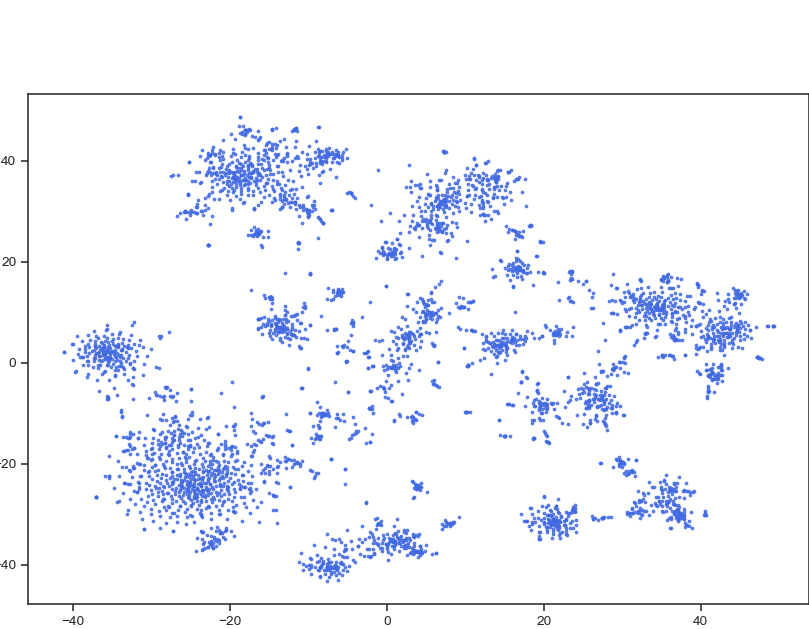

In [343]:
# Scatter plot of t-NSE
plt.figure(figsize=(9,7))
tsne_features = tsne_features_cat

plt.scatter(tsne_features[:,0], tsne_features[:,1], s=4, alpha=0.8, c='royalblue')   
        
plt.subplots_adjust(left=0.035, right=0.999, bottom=0.04, top=0.85)
plt.show()

#### 4.1.3. Hierarchical clustering

**4.1.3.1. Removing outliers**

In [ ]:
# Change the normalizer bow matrix into np.array to use for AgglomerativeClustering()
np_normalized_bow_cat = normalized_bow_cat.toarray()

In [24]:
# Agglomeral clustering setting distance_threshold=0 to compute the full tree
model_cat = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='cosine', linkage='average')
model_cat = model_cat.fit(np_normalized_bow_cat)

<IPython.core.display.Javascript object>


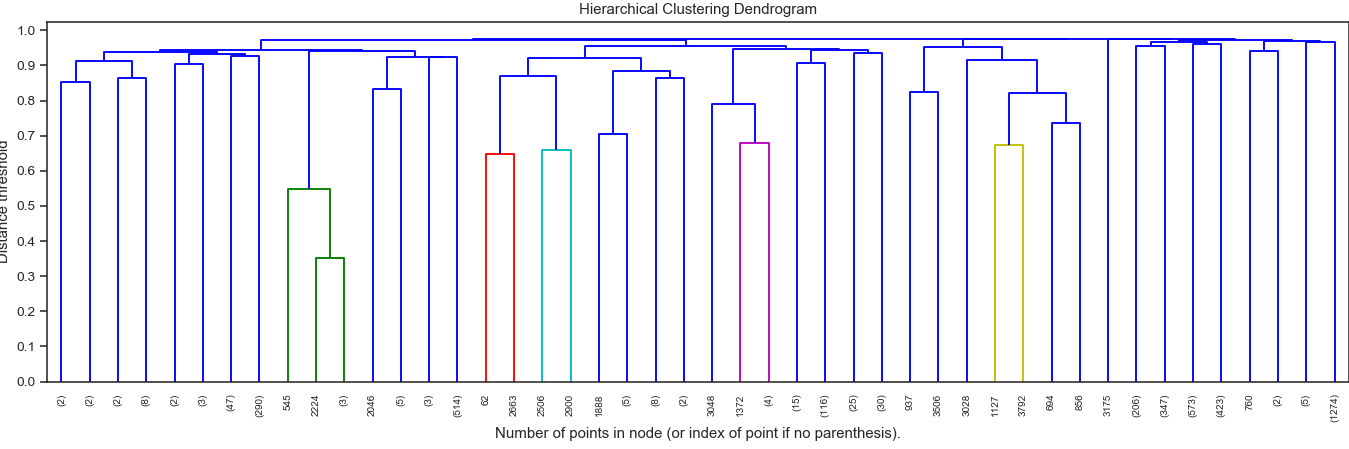

In [25]:
# Draw the dendrogram
plt.figure(figsize=(15,5))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model_cat, truncate_mode='level', p=5)

plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.subplots_adjust(left=0.035, right=0.999, bottom=0.15, top=0.95)
plt.ylabel("Distance threshold")
plt.yticks([i/10 for i in range(0,11,1)])
plt.show()

According to the dendrogram above, some mini clusters join up with the big clusters in the upper course of the dendrogram. That means the mini clusters are not very close to the main clusters. First, let's collect them as the "other" group.  
I would like to divide the data into less than 10 categories eventually. So, let's check the silhouette scores from k = 5 to 15.

In [263]:
# Agglomeral clustering from k = 5 to 15 
n_k_cat, scores_cat  = aggclus_ca_silhouette_score(5, 15, 1, np_normalized_bow_cat)

<IPython.core.display.Javascript object>


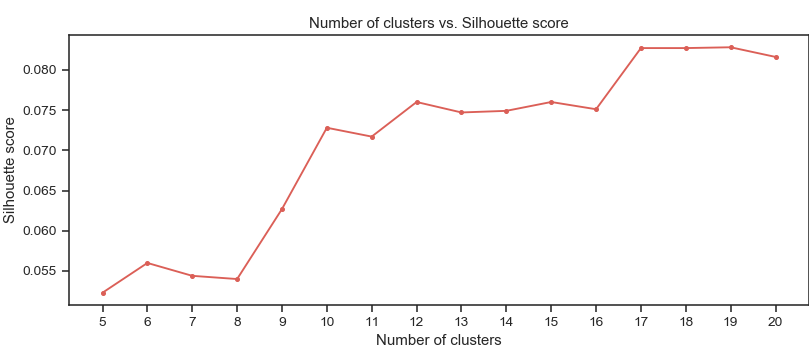

In [264]:
# Plot Number of clusters vs. Silhouette score
plt.figure(figsize=(9,4))

n_clusters = n_k_cat
sil_scores = scores_cat

plt.plot(n_clusters, sil_scores, '.-')
plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score')

plt.subplots_adjust(left=0.085, right=0.999, bottom=0.15, top=0.9)
plt.show()

Let's try k = 12.

In [265]:
# Agglomeral clustering; k = 12 
model_cat_test = AgglomerativeClustering(n_clusters=12, affinity='cosine', linkage='average')
model_cat_test = model_cat_test.fit(np_normalized_bow_cat)

<IPython.core.display.Javascript object>


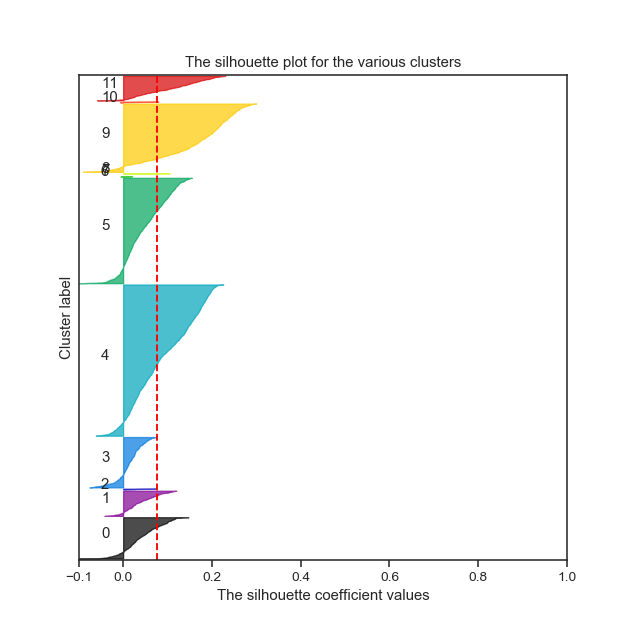

For n_clusters = 12 , The average silhouette_score is : 0.07598657439256189


In [266]:
# Silhouette plot
silhouette(model_cat_test.n_clusters_, model_cat_test.labels_, np_normalized_bow_cat)

In [267]:
# the number of products in each cluster
for i in range(model_cat_test.n_clusters_):
    print(i, ':', len(np.where(model_cat_test.labels_ == i)[0]))

0 : 347
1 : 212
2 : 7
3 : 423
4 : 1268
5 : 884
6 : 3
7 : 1
8 : 5
9 : 573
10 : 6
11 : 206


cluster_2, 6, 7, 8, 10 have a few products. Let's put them into 'other' group.

In [308]:
# Apply the labels to the product table
df_label_cat_test = df_cat_id_name[['product_id', 'product_title']]
df_label_cat_test['label'] = model_cat_test.labels_

In [569]:
# Collect the product information of 'other' group
other_clusters_cat = [2, 6, 7, 8, 10]
df_other_cat = pd.DataFrame()

for i in other_clusters_cat:
    df_other_cat = df_other_cat.append(df_label_cat_test[df_label_cat_test['label'] == i])

print(len(df_other_cat))
df_other_cat

22


,product_id,product_title,label
694,176931135,OurPets Wonder Bowl Selective Pet FeederOurPets Wonder Bowl Selective Pet FeederOurPets Wonder B...,2
856,218277179,Cat Doorbell - Wireless Indicator for your CatCat Doorbell - Wireless Indicator for your CatCat ...,2
937,237546267,"Safe Waterproof Heated Bed Pad For Dog Cat Pet, 15WSafe Waterproof Heated Bed Pad For Dog Cat Pe...",2
1127,290172374,Pestbye Battery Operated Electronic Ultrasonic Outdoor Garden Cat Repeller Repellent ScarerPestb...,2
3028,778859291,Pet Dog Cat Claw Nail Grooming Care Grinder Trimmer Clipper Electric Grooming Drill Nail File Ki...,2
3506,895012627,Rainbow Bridge Pet Sympathy Card for DogRainbow Bridge Pet Sympathy Card for DogRainbow Bridge P...,2
3792,961924410,Contech ScareCrow Outdoor Animal DeterrentContech ScareCrow Outdoor Animal DeterrentContech Scar...,2
760,192390369,The Cat in the HatThe Cat in the HatThe Cat in the HatThe Cat in the HatThe Cat in the HatThe Ca...,6
2245,576700393,"Aspen Pet Puffy Round Cat Bed (18"") Assorted ColorsAspen Pet Puffy Round Cat Bed (18"") Assorted ...",6
3644,928910893,"NaturVet Joint Support Gel for Cats, 3 oz Gel, Made in USANaturVet Joint Support Gel for Cats, 3...",6


In [ ]:
# Label each category title (from the above table)
other_category_labels_cat = {2:'other', 6:'other', 7:'other', 8:'scale', 10:'supplement'}

In [436]:
# Get the product information of cluster 0, 1, 3, 4, 5, 9, and 11
df_cat_id_name_removed = pd.DataFrame()

for i in range(len(df_cat_id_name)):
    if i not in df_other_cat.index:
        df_cat_id_name_removed = df_cat_id_name_removed.append(df_cat_id_name.iloc[i])

len(df_cat_id_name_removed)

3913

In [437]:
# Get the normalized bow matrix of cluster 0, 1, 3, 4, 5, 9, and 11
np_normalized_bow_cat_removed = np.array([np_normalized_bow_cat[i] 
                                          for i in range(len(np_normalized_bow_cat)) if i not in df_other_cat.index])
len(np_normalized_bow_cat_removed)

3913

In [438]:
# Get the t-SNE features of cluster 0, 1, 3, 4, 5, 9, and 11
tsne_features_cat_removed = np.array([tsne_features_cat[i] 
                                      for i in range(len(tsne_features_cat))if i not in df_other_cat.index])
len(tsne_features_cat_removed)

3913

**4.1.3.2. Clustering**

First, I would like to divide the data into less than 10 categories (call them big_categories). Second, each of the big_categories will be devided into subcategories (call them small_categories).  
To decide the sizes of big_categories and small_categories, let's check the silhouette scores of various cluster numbers.

In [439]:
# Agglomeral clustering; k = 5 to 50 
rough_n_k_cat, rough_scores_cat  = aggclus_ca_silhouette_score(5, 50, 5, np_normalized_bow_cat_removed)

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


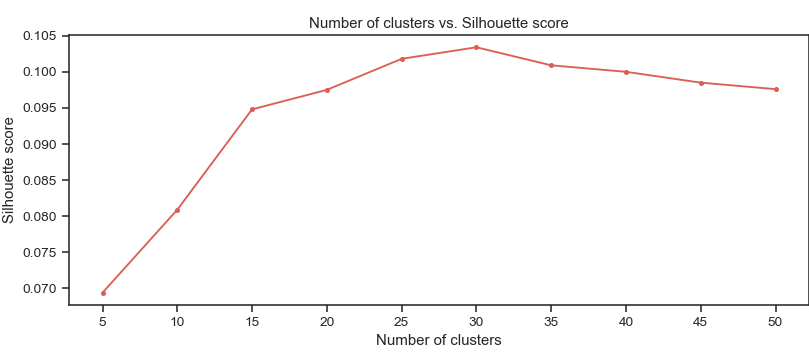

In [440]:
# Plot Number of clusters vs. Silhouette score
plt.figure(figsize=(9,4))

n_clusters = rough_n_k_cat
sil_scores = rough_scores_cat

plt.plot(n_clusters, sil_scores, '.-')
plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score')

plt.subplots_adjust(left=0.085, right=0.999, bottom=0.15, top=0.9)
plt.show()

The peak is around k = 30.  The number of small_categories would be around 30.  
To decide the number of big_categories, check k = 4 to 11. 

In [441]:
# Decide the number of big_categories
big_n_k_cat, big_scores_cat  = aggclus_ca_silhouette_score(4, 11, 1, np_normalized_bow_cat_removed)

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


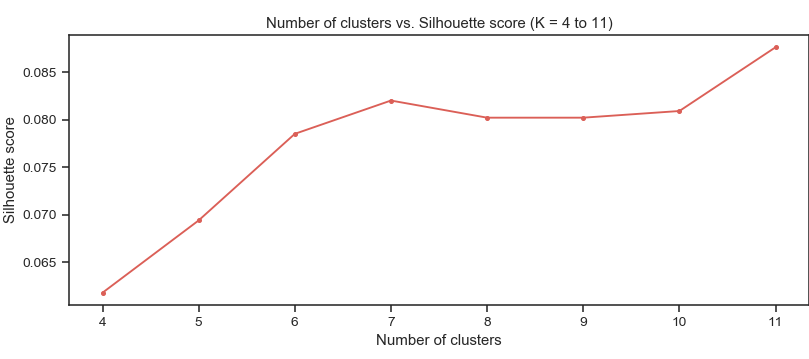

In [442]:
# Plot Number of clusters vs. Silhouette score
plt.figure(figsize=(9,4))

n_clusters = big_n_k_cat
sil_scores = big_scores_cat

plt.plot(n_clusters, sil_scores, '.-')
plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score (K = 4 to 11)')

plt.subplots_adjust(left=0.085, right=0.999, bottom=0.15, top=0.9)
plt.show()

When K = 7, the score is the maximum in less than k = 10. K = 7 is for the number of big_categories. Next, check the scores from k = 25 to 35 to choose k for the small_categories.

In [443]:
# Decide the number of medium_categories
small_n_k_cat, small_scores_cat  = aggclus_ca_silhouette_score(25, 35, 1, np_normalized_bow_cat_removed)

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


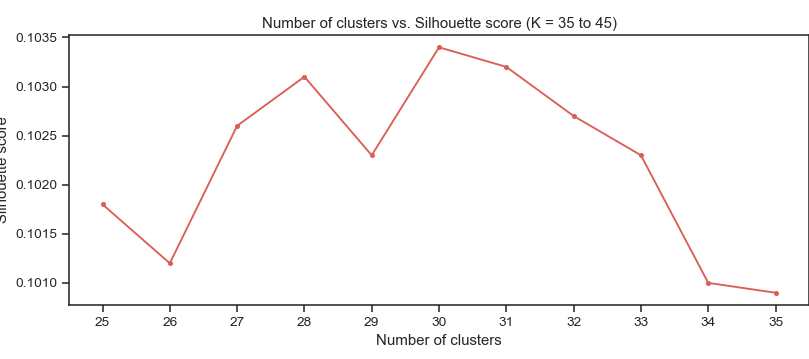

In [444]:
# Plot Number of clusters vs. Silhouette score
plt.figure(figsize=(9,4))

n_clusters = small_n_k_cat
sil_scores = small_scores_cat

plt.plot(n_clusters, sil_scores, '.-')
plt.xticks(n_clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Number of clusters vs. Silhouette score (K = 35 to 45)')

plt.subplots_adjust(left=0.085, right=0.999, bottom=0.15, top=0.9)
plt.show()

K = 30 for the small_categories.  
First, let's try k = 7 for the big_categories.

In [445]:
# Agglomerative clustering (n_clusters=7, big_categories)
n_clusters=7

model_cat_7 = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')
model_cat_7 = model_cat_7.fit(np_normalized_bow_cat_removed)

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


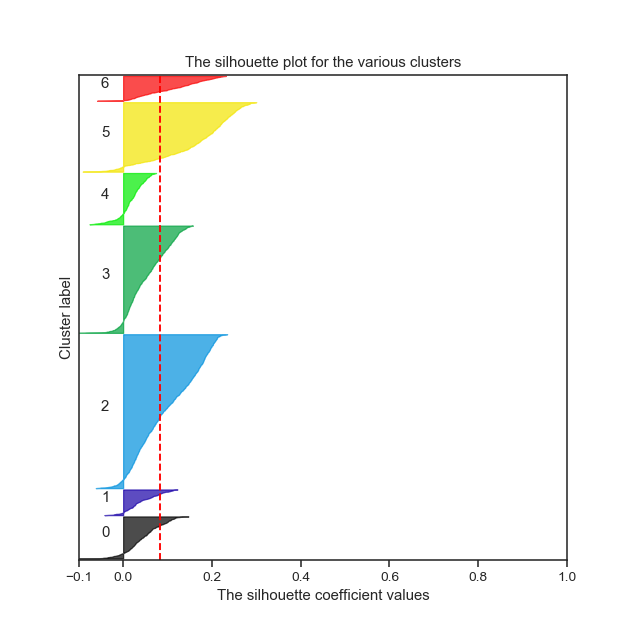

For n_clusters = 7 , The average silhouette_score is : 0.08198922723275429


In [446]:
# Plot silhouette scores
silhouette(model_cat_7.n_clusters_, model_cat_7.labels_, np_normalized_bow_cat_removed)

In [447]:
# Add the labels on the product information
df_label_cat = df_cat_id_name_removed[['product_id', 'product_title']]
df_label_cat['label_7'] = model_cat_7.labels_

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


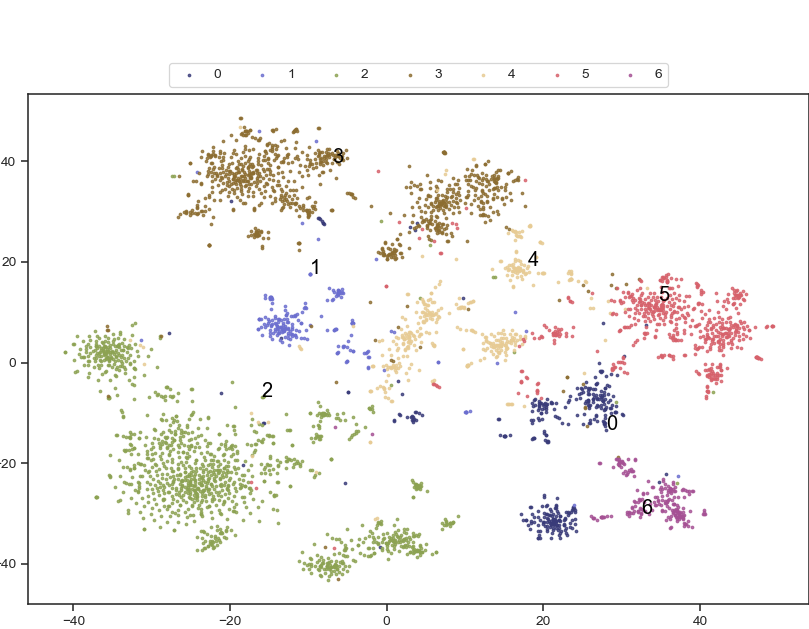

In [448]:
# Scatter plot, colored by the labels
plt.figure(figsize=(9,7))

model = model_cat_7
tsne_features = tsne_features_cat_removed

for i in range(model.n_clusters_):
    plt.scatter(tsne_features[model.labels_ == i][:,0], 
                tsne_features[model.labels_ == i][:,1], 
                s=4, alpha=0.8, c=[cmap1(i/model.n_clusters_)], label=i)   
    plt.text(tsne_features[model.labels_ == i][:,0][0],
             tsne_features[model.labels_ == i][:,1][0],
             str(i), color="black", size=16
             )
        
plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=10)
plt.subplots_adjust(left=0.035, right=0.999, bottom=0.04, top=0.85)
plt.show()

In [449]:
# Count the number of products in each clusters
frequent_words(df_label_cat, 'label_7', new_cat_token_list)

,frequent words,number of products
cluster number,,
0,"(dog, smell, stuff, spray, flea, carpet, spot, odor, bottl, stain)",347
1,"(collar, fit, color, dog, bell, neck, comfort, design, materi, tag)",212
2,"(food, eat, dog, dri, water, feed, treat, stuff, bowl, flavor)",1268
3,"(play, toy, scratch, interest, fun, sturdi, box, catnip, room, post)",884
4,"(dog, room, door, comfort, fit, carrier, bed, pad, box, sturdi)",423
5,"(litter, box, smell, scoop, odor, clump, bag, floor, room, stuff)",573
6,"(hair, dog, brush, groom, coat, fur, comb, tool, hand, cut)",206


In [450]:
# Check the products in each cluster
df_label_cat[df_label_cat['label_7'] == 0].sample(20)

,product_id,product_title,label_7
1981,505357977.0,Vetri-Science Laboratories Glyco-Flex II Bite-Sized Cat ChewsVetri-Science Laboratories Glyco-Fl...,0
1915,491692358.0,Unique Natural Products 203 Pet Odor and Stain EliminatorUnique Natural Products 203 Pet Odor an...,0
3650,929950820.0,Pet Organics No-Mark for CatsPet Organics No-Mark for CatsPet Organics No-Mark for CatsPet Organ...,0
3667,934402390.0,Nature's Miracle Scented Stain and Odor RemoverNature's Miracle Scented Stain and Odor RemoverNa...,0
923,234644684.0,Advantage II Small Cat 6-PackAdvantage II Small Cat 6-PackAdvantage II Small Cat 6-PackAdvantage...,0
3431,877761959.0,"Nature's Miracle Pet Bath Wipes, 70-CountNature's Miracle Pet Bath Wipes, 70-CountNature's Mirac...",0
3054,785814062.0,Dermoscent Essential 6 - CatsDermoscent Essential 6 - CatsDermoscent Essential 6 - CatsDermoscen...,0
1872,478424098.0,"Nootie- Pet Shampoo, 1 Unit 16oz, Warm Vanilla CookieNootie- Pet Shampoo, 1 Unit 16oz, Warm Vani...",0
266,68347309.0,"Knockout Area Treatment by Virbac (14 oz)Virbac Knockout Area Treatment, 14 oz. SprayVirbac Knoc...",0
1777,452386232.0,Eye Envy NR 4oz Tear Stain Remover Solution for CatsEye Envy NR 4oz Tear Stain Remover Solution ...,0


In [529]:
# Label each category title (from the above two tables)
big_category_labels_cat = {0:"flea, odor, stain", 1:"collar, leash, costume", 2:"food, water", 
                           3:"toy, scratcher, cat tree", 4:"door, cage, carrier, bed", 5:"litter", 6:"grooming"}

Next, let's try k = 30 for small_categories.

In [452]:
# Agglomerative clustering (n_clusters=30, small_categories)
n_clusters=30

model_cat_30 = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')
model_cat_30 = model_cat_30.fit(np_normalized_bow_cat_removed)

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


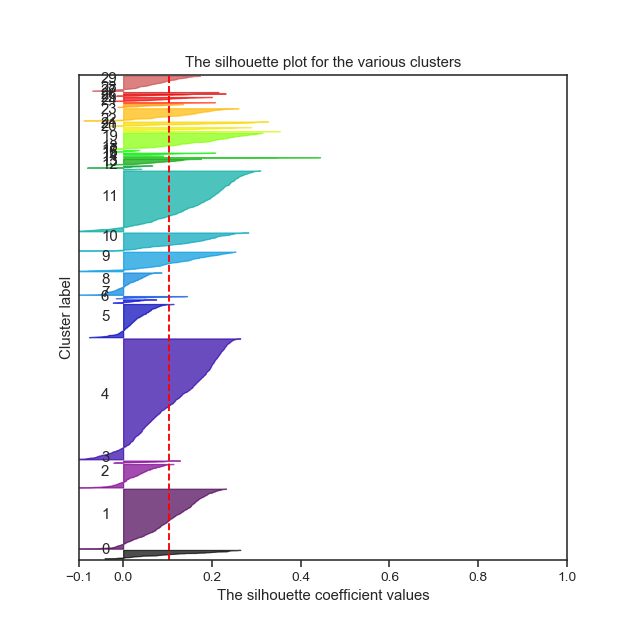

For n_clusters = 30 , The average silhouette_score is : 0.10343589193290639


In [455]:
# Plot silhouette scores
silhouette(model_cat_30.n_clusters_, model_cat_30.labels_, np_normalized_bow_cat_removed)

In [453]:
# Add the labels on the product information
df_label_cat['label_30'] = model_cat_30.labels_

In [456]:
# Get the t-SNE features of each big_category
tsne_features_cat_divided = []
for k in range(7):
    indexes = df_label_cat[df_label_cat['label_7'] == k].index
    features = []
    for i in range(len(tsne_features_cat)):
        if i in indexes:
            features.append(tsne_features_cat[i])
    tsne_features_cat_divided.append(np.array(features))
    
len(tsne_features_cat_divided)

7

In [457]:
# Scatter plot, colored by the labels (interactive plot)

@interact(mode=['all', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5', 'Cluster_6'])

def interactive_plot(mode):
    if mode == 'all':
        plt.figure(figsize=(9,7))
        model = model_cat_30
        tsne_features = tsne_features_cat_removed

        for i in range(model.n_clusters_):
            plt.scatter(tsne_features[model.labels_ == i][:,0], 
                        tsne_features[model.labels_ == i][:,1], 
                        s=4, alpha=0.8, c=[cmap1(i/model.n_clusters_)], label=i)   
            plt.text(tsne_features[model.labels_ == i][:,0][0],
                     tsne_features[model.labels_ == i][:,1][0],
                     str(i), color="black", size=16)
    else:
        number = int(mode[8])
        cluster_plot(tsne_features_cat_divided, number, df_label_cat, 'label_7', 'label_30')
    
    plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=10)
    plt.subplots_adjust(left=0.035, right=0.999, bottom=0.04, top=0.85)
    plt.xlim(-45, 55)
    plt.ylim(-50, 55)
    plt.show()

interactive(children=(Dropdown(description='mode', options=('all', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Clu…

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


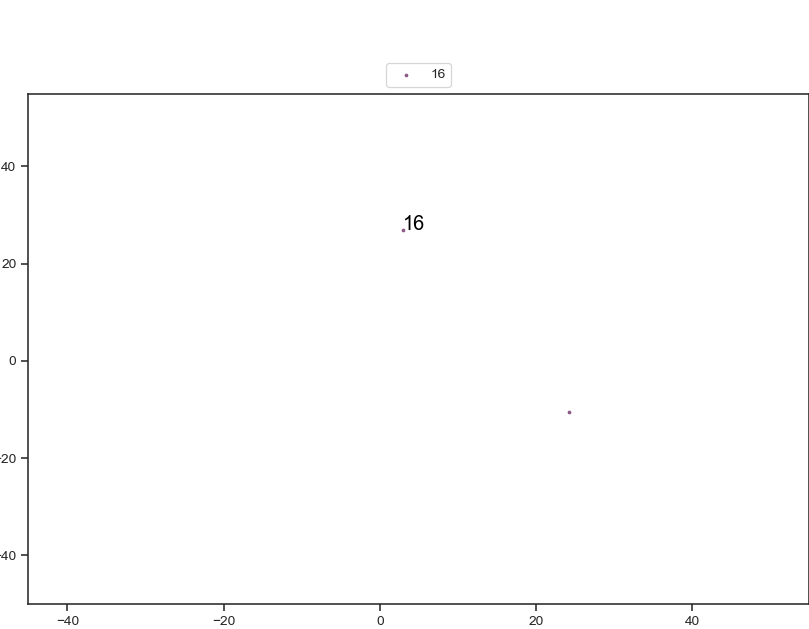

In [490]:
# Scatter plot, colored by the labels (non_interactive plot)
plt.figure(figsize=(9,7))

model = model_cat_30
tsne_features = tsne_features_cat_removed

for i in range(model.n_clusters_):
    plt.scatter(tsne_features[model.labels_ == i][:,0], 
                tsne_features[model.labels_ == i][:,1], 
                s=4, alpha=0.8, c=[cmaps[i]], label=i)   
    plt.text(tsne_features[model.labels_ == i][:,0][0],
             tsne_features[model.labels_ == i][:,1][0],
             str(i), color="black", size=16)
        
plt.legend(loc='lower center', bbox_to_anchor=(.5, 1), ncol=10)
plt.subplots_adjust(left=0.035, right=0.999, bottom=0.04, top=0.85)
plt.xlim(-45, 55)
plt.ylim(-50, 55)
plt.show()

In [459]:
# Count the number of products in each clusters
n_clusters = df_label_cat['label_30'].nunique()
df_30cluster_cat = pd.DataFrame(columns=['big_category_number', 'small_category_number','frequent words', 'number of products'])
for i in range(n_clusters):
    words = []
    indexes = df_label_cat[df_label_cat['label_30'] == i].index
    big_category_number = df_label_cat[df_label_cat['label_30'] == i].iat[0, 2]
    for index in indexes:
        for word in set(new_cat_token_list[index]):
            words.append(word)
    c = Counter(words)
    values, _ = zip(*c.most_common(10))

    df_temp = pd.DataFrame([[big_category_number, i, values, len(indexes)]], 
                                columns=df_30cluster_cat.columns)
    df_30cluster_cat = df_30cluster_cat.append(df_temp) 

df_30cluster_cat.set_index(['big_category_number']).sort_index()

,small_category_number,frequent words,number of products
big_category_number,,,
0,2,"(smell, spray, stuff, dog, odor, carpet, spot, stain, bottl, pee)",205
0,19,"(flea, dog, stuff, treatment, vet, spray, scratch, appli, tick, sinc)",140
0,16,"(mark, anyon, collar, calm, point, couch, tablet, dog, packag, prayer)",2
1,29,"(collar, bell, color, fit, neck, dog, tag, materi, scratch, design)",131
1,3,"(beauti, rest, belov, custom, dog, design, color, fit, engrav, stone)",20
1,25,"(cone, comfort, plastic, recoveri, box, shame, neck, fit, design, tube)",6
1,6,"(fit, dog, color, velcro, medium, tie, ador, strap, dress, photo)",30
1,21,"(har, leash, fit, walk, dog, comfort, color, strap, neck, clip)",25
2,27,"(tank, gallon, aquarium, water, top, fit, stuff, packag, today, sturdi)",20


In [491]:
# Check the products in each cluster
df_label_cat[df_label_cat['label_30'] == 2].sample(20)

,product_id,product_title,label_7,label_30
62,13069698.0,"Petrageous Designs City Pets Cat Lover Mug, 20 ozPetrageous Designs City Pets Cat Lover Mug, 20 ...",1,3
73,15248225.0,Petparty Adorable Bunny Halloween Dog Costumes Dog Hoodie Jumpsuit Dog Coat Pet Dog ClothesPetpa...,1,3
406,109416259.0,Sandblast Engraved Marble Pet Memorial Headstone Grave Marker Dog Cat keep 6x12Sandblast Engrave...,1,3
553,143339059.0,"Top Collection 9.5"" Egyptian Bastet Goddess Cat Cremation Urn. Authentic Replica of Goddess Bast...",1,3
639,162781311.0,Personalized Pet Memorial Stone Small Size Durable ResinPersonalized Pet Memorial Stone Small Si...,1,3
954,241567613.0,"Cat Urn - Personalized, Engraved Angel Cat Urn. A Beautiful Custom Cremation Urn for Pets & Memo...",1,3
1151,298126739.0,Near & Dear Pet Memorials Elite Cat Resin Cremation UrnNear & Dear Pet Memorials Elite Cat Resin...,1,3
1299,331181045.0,Near & Dear Pet Memorials Silhouette Cat UrnNear & Dear Pet Memorials Silhouette Cat UrnNear & D...,1,3
1484,373412827.0,Odyssey Series Pet Cremation UrnsOdyssey Series Pet Cremation UrnsOdyssey Series Pet Cremation U...,1,3
1597,401365685.0,Sandblast Engraved River Stone Pet Memorial Headstone Grave Marker Dog Cat h medSandblast Engrav...,1,3


In [495]:
# Label each category title (from the above two tables)
small_category_labels_cat = {2:"odor, stain, shampoo", 19:"flea", 16:"odor, stain, shampoo",
                             29:"collar", 3:"memorial", 25:"recovery collar", 6:"costume", 21:"harness, leash", 
                             27:"aquarium", 4:"food, treat", 22:"pill, treatment", 10:"bowl, fountain, filter", 
                             18:"other", 15:"catnip toy", 14:"nail cap, furniture protector", 12:"scratcher, cat tree", 
                             5:"scratcher, cat tree", 1:"toy", 
                             8:"bed", 7:"cage, hammock", 23:"carrier, kennel", 24:"perch, shelf", 0:"door, deterrent, trap",
                             13:"calming", 17:"mat", 11:"litter, litter box", 20:"sand", 28:"scratcher, cat tree",
                             9:"brush. comb", 26:"clipper"}

Small_cluster_27 and 20 are not for cats, but others.  
Small_cluster_18 is miscellaneous, and should have been 'other'.    
Small_cluster_28 is in big_category_5, but should have been big_category_3.  
Small_cluster_3 is in big_category_1, but should have been 'other'.

In [562]:
# Make a new datafeame
df_label_cat_summary = df_label_cat

# Add 'animal' column
df_label_cat_summary['animal'] = 'cat'
df_label_cat_summary.head()

,product_id,product_title,label_7,label_30,animal
0,70064.0,Perfect Pet Soft Flap Cat Door with Telescoping FramePerfect Pet Soft Flap Cat Door with Telesco...,4,0,cat
1,593896.0,Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set o...,2,4,cat
2,919291.0,Basis Pet Made in the USA Low Profile Stainless Steel Cat DishBasis Pet Made in the USA Low Prof...,2,4,cat
3,944764.0,Alfie Pet by Petoga Couture - Vea 2.0 Slow-Eating Anti-Gulping Pet Food Bowl (for Dogs & Cats)Al...,2,4,cat
4,1124833.0,Petmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate H...,5,11,cat
...,...,...,...,...,...
3930,999135471.0,NaturVet Naturals Dog & Cat Allergy Aid Soft ChewsNvet Aller-911 Sft Chew 90ctNaturVet Naturals ...,2,4,cat
3931,999281618.0,Nature's Variety Pride by Instinct Grain Free Dry Cat FoodNature's Variety Pride by Instinct Gra...,2,4,cat
3932,999404580.0,Purina Friskies Party Mix Naturals Cat Treats - 10-2.1 oz. PouchesPurina Friskies Party Mix Natu...,2,4,cat
3933,999408900.0,Wicker Cat Litter Pan CoverWicker Cat Litter Pan CoverWicker Cat Litter Pan CoverWicker Cat Litt...,5,11,cat


In [563]:
# Take care of mis-categorized products
for i in range(len(df_label_cat_summary)):
    if df_label_cat_summary.iloc[i, 3] == 27:
        df_label_cat_summary.iloc[i, 2] = 'aquarium'
        df_label_cat_summary.iloc[i, 4] = 'other'
    elif df_label_cat_summary.iloc[i, 3] == 20:
        df_label_cat_summary.iloc[i, 2] = 'sand'
        df_label_cat_summary.iloc[i, 4] = 'other'
    elif df_label_cat_summary.iloc[i, 3] == 18:
        df_label_cat_summary.iloc[i, 2] = 'other'
    elif df_label_cat_summary.iloc[i, 3] == 28:
        df_label_cat_summary.iloc[i, 2] = 3
    elif df_label_cat_summary.iloc[i, 3] == 3:
        df_label_cat_summary.iloc[i, 2] = 'other'
        
df_label_cat_summary.head()

,product_id,product_title,label_7,label_30,animal
0,70064.0,Perfect Pet Soft Flap Cat Door with Telescoping FramePerfect Pet Soft Flap Cat Door with Telesco...,4,0,cat
1,593896.0,Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set o...,2,4,cat
2,919291.0,Basis Pet Made in the USA Low Profile Stainless Steel Cat DishBasis Pet Made in the USA Low Prof...,2,4,cat
3,944764.0,Alfie Pet by Petoga Couture - Vea 2.0 Slow-Eating Anti-Gulping Pet Food Bowl (for Dogs & Cats)Al...,2,4,cat
4,1124833.0,Petmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate H...,5,11,cat
...,...,...,...,...,...
3930,999135471.0,NaturVet Naturals Dog & Cat Allergy Aid Soft ChewsNvet Aller-911 Sft Chew 90ctNaturVet Naturals ...,2,4,cat
3931,999281618.0,Nature's Variety Pride by Instinct Grain Free Dry Cat FoodNature's Variety Pride by Instinct Gra...,2,4,cat
3932,999404580.0,Purina Friskies Party Mix Naturals Cat Treats - 10-2.1 oz. PouchesPurina Friskies Party Mix Natu...,2,4,cat
3933,999408900.0,Wicker Cat Litter Pan CoverWicker Cat Litter Pan CoverWicker Cat Litter Pan CoverWicker Cat Litt...,5,11,cat


In [566]:
# Replace the category numbers into the names
df_label_cat_summary = df_label_cat.replace({'label_7': big_category_labels_cat,
                                             'label_30': small_category_labels_cat})
# Rename the columns
df_label_cat_summary = df_label_cat_summary.rename(columns={'label_7': 'big_category', 'label_30': 'small_category'})

df_label_cat_summary.head()

,product_id,product_title,big_category,small_category,animal
0,70064.0,Perfect Pet Soft Flap Cat Door with Telescoping FramePerfect Pet Soft Flap Cat Door with Telesco...,"door, cage, carrier, bed","door, deterrent, trap",cat
1,593896.0,Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set o...,"food, water","food, treat",cat
2,919291.0,Basis Pet Made in the USA Low Profile Stainless Steel Cat DishBasis Pet Made in the USA Low Prof...,"food, water","food, treat",cat
3,944764.0,Alfie Pet by Petoga Couture - Vea 2.0 Slow-Eating Anti-Gulping Pet Food Bowl (for Dogs & Cats)Al...,"food, water","food, treat",cat
4,1124833.0,Petmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate H...,litter,"litter, litter box",cat
...,...,...,...,...,...
3930,999135471.0,NaturVet Naturals Dog & Cat Allergy Aid Soft ChewsNvet Aller-911 Sft Chew 90ctNaturVet Naturals ...,"food, water","food, treat",cat
3931,999281618.0,Nature's Variety Pride by Instinct Grain Free Dry Cat FoodNature's Variety Pride by Instinct Gra...,"food, water","food, treat",cat
3932,999404580.0,Purina Friskies Party Mix Naturals Cat Treats - 10-2.1 oz. PouchesPurina Friskies Party Mix Natu...,"food, water","food, treat",cat
3933,999408900.0,Wicker Cat Litter Pan CoverWicker Cat Litter Pan CoverWicker Cat Litter Pan CoverWicker Cat Litt...,litter,"litter, litter box",cat


In [570]:
# Take care of df_other_cat to merge it with df_label_cat_summary
# Replace the category numbers into the names
df_other_cat = df_other_cat.replace({'label': other_category_labels_cat})

# Replace the category numbers into the names
df_other_cat = df_other_cat.rename(columns={'label': 'small_category'})

# Add 'big_category' column
df_other_cat['big_category'] = 'other'

# Add 'animal' column
df_other_cat['animal'] = 'cat'

df_other_cat.haed()

In [572]:
# Merge df_label_cat_summary and df_other_cat
df_label_cat_summary = df_label_cat_summary.append(df_other_cat)
df_label_cat_summary.head()

,product_id,product_title,big_category,small_category,animal
0,70064.0,Perfect Pet Soft Flap Cat Door with Telescoping FramePerfect Pet Soft Flap Cat Door with Telesco...,"door, cage, carrier, bed","door, deterrent, trap",cat
1,593896.0,Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set of 3Pet Food Can Covers Lids Set o...,"food, water","food, treat",cat
2,919291.0,Basis Pet Made in the USA Low Profile Stainless Steel Cat DishBasis Pet Made in the USA Low Prof...,"food, water","food, treat",cat
3,944764.0,Alfie Pet by Petoga Couture - Vea 2.0 Slow-Eating Anti-Gulping Pet Food Bowl (for Dogs & Cats)Al...,"food, water","food, treat",cat
4,1124833.0,Petmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate Hooded Cat Litter PanPetmate H...,litter,"litter, litter box",cat
...,...,...,...,...,...
473,126733564.0,Wee Cleaner - Pet Urine Odor Remover for Cat and Dog Urine (1-gallon bottle)Wee Cleaner - Pet Ur...,other,other,cat
1505,377349050.0,Hartz Precision Nutrition Adult Cat Multi Vitamins with PrebioticsHartz Precision Nutrition Adul...,other,other,cat
1532,384301678.0,Reptaid - 1 fl oz.- An herbal Supplement to help your small reptiles overcome some parasitic and...,other,other,cat
2041,521996119.0,"Zilla Reptile Health Supplies Jump-Start Appetite Stimulant, 4.25-oz.Zilla Reptile Health Suppli...",other,other,cat


This df_label_cat_summary shows the category label of each product.  
Let's make a table to show the number of products of each cluster.

In [539]:
# Make a new dataframe from df_30cluster_cat
df_cat_summary_numbers = df_30cluster_cat[['big_category_number', 'small_category_number','number of products']]
df_cat_summary_categories = df_cat_summary_numbers.replace({'big_category_number': big_category_labels_cat,
                                                            'small_category_number': small_category_labels_cat
                                                            })
# Make a new dataframe for 'other' group
df_other_summary_cat = pd.DataFrame({'big_category_number': 'other',
                                 'small_category_number':'other', 
                                 'number of products':22}, index=[0])

# Merge the two dataframes
df_cat_summary_categories = df_cat_summary_categories.append(df_other_summary_cat)
df_cat_summary_categories['animal'] = 'cat'

,big_category_number,small_category_number,number of products,animal
0,"door, cage, carrier, bed","door, deterrent, trap",76,cat
0,"toy, scratcher, cat tree",toy,523,cat
0,"flea, odor, stain","odor, stain, shampoo",205,cat
0,"collar, leash, costume",memorial,20,cat
0,"food, water","food, treat",1053,cat
0,"toy, scratcher, cat tree","scratcher, cat tree",290,cat
0,"collar, leash, costume",costume,30,cat
0,"door, cage, carrier, bed","cage, hammock",19,cat
0,"door, cage, carrier, bed",bed,195,cat
0,grooming,brush. comb,171,cat


In [574]:
# Take care of mis_cateforizations
# Change the animal_category of small_cluster_27 ('aquarium' ) to 'other' animal 
df_cat_summary_categories.iloc[27,3] = 'other'

# Change the big_category of small_cluster_27 ('aquarium' ) to 'aquarium' animal 
df_cat_summary_categories.iloc[27,0] = 'aquarium'

# Change the animal_category of small_cluster_20 ('sand') to 'other' animal
df_cat_summary_categories.iloc[20,3] = 'other'

# Change big_category of small_cluster_20 ('sand') into 'sand' 
df_cat_summary_categories.iloc[20,0] = 'sand'

# Change the big_category of Small_cluster_18 ('other') into 'other'
df_cat_summary_categories.iloc[18,0] = 'other'

# Change 'memorial' row to 'other' big_category
df_cat_summary_categories.iloc[3,0] = 'other'

# Correct the big category to 'toy, scratcher, cat tree'
df_cat_summary_categories.iloc[-3,0] = 'toy, scratcher, cat tree'

# Rename the column names
df_cat_summary_categories = df_cat_summary_categories.rename(columns={'big_category_number': 'big_category', 
                                                                      'small_category_number': 'small_category'})

,big_category,small_category,number of products,animal
0,"door, cage, carrier, bed","door, deterrent, trap",76,cat
0,"toy, scratcher, cat tree",toy,523,cat
0,"flea, odor, stain","odor, stain, shampoo",205,cat
0,other,memorial,20,cat
0,"food, water","food, treat",1053,cat
0,"toy, scratcher, cat tree","scratcher, cat tree",290,cat
0,"collar, leash, costume",costume,30,cat
0,"door, cage, carrier, bed","cage, hammock",19,cat
0,"door, cage, carrier, bed",bed,195,cat
0,grooming,brush. comb,171,cat


In [575]:
# Groupby 'animal', 'big_category', 'small_category'
df_cat_summary_categories.groupby(['animal', 'big_category', 'small_category']).sum()

number of products
animal big_category             small_category                                   
cat    collar, leash, costume   collar                                        131
                                costume                                        30
                                harness, leash                                 25
                                recovery collar                                 6
       door, cage, carrier, bed bed                                           195
                                cage, hammock                                  19
                                carrier, kennel                               106
                                door, deterrent, trap                          76
                                perch, shelf                                   27
       flea, odor, stain        flea                                          140
                                odor, stain, shampoo                          207
       food, water              bowl, fountain, filter                        157
                                food, treat                                  1053
                                pill, treatment                                38
       grooming                 brush. comb                                   171
                                clipper                                        35
       litter                   calming                                        20
                                litter, litter box                            529
                                mat                                            17
       other                    memorial                                       20
                                other                                          36
       toy, scratcher, cat tree catnip toy                                      5
                                nail cap, furniture protector                  47
                                scratcher, cat tree                           298
                                toy                                           523
other  aquarium                 aquarium                                       20
       sand                     sand                                            4